In [1]:
import glob
import os
import sigmf
import torch
import torchsig

import numpy as np
import torch.nn.functional as F
import torchsig.transforms as ST

from datetime import datetime
from models import CustomNetwork
from pathlib import Path
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from sigmf_db_dataset import SigMFDB
from sigmf_pytorch_dataset import SigMFDataset
from sklearn.metrics import classification_report
from torchsig.models.iq_models.efficientnet.efficientnet import efficientnet_b4
from torchsig.transforms import (
    Compose,
    IQImbalance,
    Normalize,
    RandomApply,
    RandomFrequencyShift,
    RandomPhaseShift,
    RandomResample,
    RandomTimeShift,
    RayleighFadingChannel,
    TargetSNR,
    ComplexTo2D,
)
from torchsig.utils.cm_plotter import plot_confusion_matrix
from torchsig.utils.dataset import SignalDataset
from torchsig.utils.visualize import IQVisualizer, SpectrogramVisualizer, two_channel_to_complex
from tqdm import tqdm
from typing import List


import data as data_class
import annotation_utils

# Parameters

In [2]:
data_directory = "data/gamutrf/gamutrf-sd-gr-ieee-wifi/test_offline/"
model_file = "weights/checkpoint-v17_torchscript.pt"
num_iq_samples = 1024
only_use_start_of_burst = True
idx_to_class = {
  0: 'anom_wifi',
  1: 'mini2_telem',
  2: 'mini2_video',
  3: 'wifi6',
  4: 'wifi',
  5: 'fhss_css'
}

# Prepare detection/samples to be sent for inference
## Requirements 
1. zst or sigmf-data/meta file (zst files will be automatically converted to sigmf)

# Option 1: (known labels, i.e. manual collection) Create labelled SigMF-Meta annotations 

In [3]:
# for f in tqdm(glob.glob(str(Path(data_directory,"anom*.sigmf-data")))):
#     annotation_utils.annotate(f, label="anom_wifi", avg_window_len=256, avg_duration=3, debug=True)

# for f in tqdm(glob.glob(str(Path(data_directory,"wifi*.sigmf-data")))):
#     annotation_utils.annotate(f, label="wifi", avg_window_len=256, avg_duration=3, debug=True)

# Option 2: (unknown labels) Create SigMF-Meta annotations without core:label

  0%|                                                                        | 0/1 [00:00<?, ?it/s]/home/ltindall/.pyenv/versions/3.10.9/envs/rfml-dev/lib/python3.10/site-packages/sigmf/sigmffile.py:914: UserWarning: Compliant Dataset `data/gamutrf/gamutrf-sd-gr-ieee-wifi/test_offline/anomwifi-encoding-0-sendsps-10000000.s16.zst.sigmf-data` exists but "core:dataset" is also defined; using `data/gamutrf/gamutrf-sd-gr-ieee-wifi/test_offline/anomwifi-encoding-0-sendsps-10000000.s16.zst.sigmf-data`
  warnings.warn(f'Compliant Dataset `{compliant_data_fn}` exists but '



Loaded 
 Data file: data/gamutrf/gamutrf-sd-gr-ieee-wifi/test_offline/anomwifi-encoding-0-sendsps-10000000.s16.zst.sigmf-data 
 SigMF-Meta file: data/gamutrf/gamutrf-sd-gr-ieee-wifi/test_offline/anomwifi-encoding-0-sendsps-10000000.s16.zst.sigmf-meta

np.max(avg_pwr_db)=-52.91095836544167
np.mean(avg_pwr_db)=-63.19792321336329
median absolute deviation threshold = -61.74815892865216
using threshold = -61.74815892865216


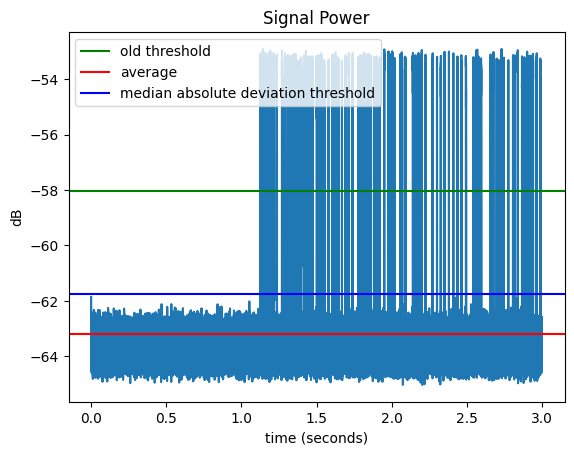

100%|████████████████████████████████████████████████████████████████| 1/1 [01:05<00:00, 65.80s/it]

Writing 1137 annotations to data/gamutrf/gamutrf-sd-gr-ieee-wifi/test_offline/anomwifi-encoding-0-sendsps-10000000.s16.zst.sigmf-meta


In [4]:
for f in tqdm(glob.glob(str(Path(data_directory,"*.sigmf-data")))):
    annotation_utils.annotate(f, label=None, avg_window_len=256, avg_duration=3, debug=True)

# Create SigMF Dataset

In [5]:
transform = ST.Compose([
    ST.Normalize(norm=np.inf),
    ST.ComplexTo2D(),
])
dataset = SigMFDataset( 
    root=data_directory, 
    sample_count= num_iq_samples, 
    # class_list = list(idx_to_class.values()),
    transform = transform,
    only_first_samples=only_use_start_of_burst,
)

Adding None to class list
Class List: [None]


# Load Model

In [6]:
model = torch.jit.load(model_file)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

example_model = CustomNetwork(model)

example_model = example_model.eval()
example_model = example_model.cuda() if torch.cuda.is_available() else example_model

# Create/Reset prediction_* SigMF-Meta files

In [13]:
annotation_utils.reset_predictions_sigmf(dataset)


Loaded 
 Data file: data/gamutrf/gamutrf-sd-gr-ieee-wifi/test_offline/anomwifi-encoding-0-sendsps-10000000.s16.zst.sigmf-data 
 SigMF-Meta file: data/gamutrf/gamutrf-sd-gr-ieee-wifi/test_offline/anomwifi-encoding-0-sendsps-10000000.s16.zst.sigmf-meta

Reset annotations in data/gamutrf/gamutrf-sd-gr-ieee-wifi/test_offline/prediction_anomwifi-encoding-0-sendsps-10000000.s16.zst.sigmf-meta


# Run inference on dataset

In [14]:
example_model.eval()

data_obj_dict = {}
sigmf_obj_dict = {}
for i in tqdm(range(len(dataset))):

    # Run inference
    data = torch.tensor(dataset[i][0]).float().reshape(1,2,-1)
    data = data.cuda() if torch.cuda.is_available() else data
    pred_tmp = example_model.predict(data)
    pred_tmp = pred_tmp.cpu().numpy() if torch.cuda.is_available() else pred_tmp
    prediction_class = idx_to_class[np.argmax(pred_tmp, axis=1)[0]]

    # Prepare SigMF data 
    data_file = dataset.index[i][1].absolute_path
    if data_file not in data_obj_dict:
        data_obj = data_class.Data(data_file)
        data_obj_dict[data_file] = data_obj
    else:
        data_obj = data_obj_dict[data_file]
    
    sample_size = dataset.index[i][1].item_type.itemsize * (
        2 if "c" in data_obj.metadata["global"]["core:datatype"] else 1
    )
    sample_start = int(dataset.index[i][1].byte_offset/sample_size)
    metadata = {
        "core:label": prediction_class,
        "core:freq_lower_edge": data_obj.metadata["captures"][0]["core:frequency"]
        - data_obj.metadata["global"]["core:sample_rate"] / 2,
        "core:freq_upper_edge": data_obj.metadata["captures"][0]["core:frequency"]
        + data_obj.metadata["global"]["core:sample_rate"] / 2,
    }

    # Add new annotations 
    prediction_meta_path = Path(Path(data_obj.sigmf_meta_filename).parent, f"prediction_{Path(data_obj.sigmf_meta_filename).name}")
    if prediction_meta_path not in sigmf_obj_dict:
        temp_sigmf_obj = sigmf.sigmffile.fromfile(prediction_meta_path)
        sigmf_obj_dict[prediction_meta_path] = temp_sigmf_obj
    else:
        temp_sigmf_obj = sigmf_obj_dict[prediction_meta_path]
    
    temp_sigmf_obj.add_annotation(sample_start, length=num_iq_samples, metadata=metadata)

# Write prediction_* SigMF-Meta 
for prediction_meta_path, temp_sigmf_obj in sigmf_obj_dict.items():
    temp_sigmf_obj.tofile(prediction_meta_path, skip_validate=True)
    print(f"Writing prediction annotation to {prediction_meta_path}")


  0%|                                                                      | 0/904 [00:00<?, ?it/s]


Loaded 
 Data file: data/gamutrf/gamutrf-sd-gr-ieee-wifi/test_offline/anomwifi-encoding-0-sendsps-10000000.s16.zst.sigmf-data 
 SigMF-Meta file: data/gamutrf/gamutrf-sd-gr-ieee-wifi/test_offline/anomwifi-encoding-0-sendsps-10000000.s16.zst.sigmf-meta



100%|████████████████████████████████████████████████████████████| 904/904 [00:11<00:00, 80.33it/s]

Writing prediction annotation to data/gamutrf/gamutrf-sd-gr-ieee-wifi/test_offline/prediction_anomwifi-encoding-0-sendsps-10000000.s16.zst.sigmf-meta
